# Data Analytics for Health - Task 2.3: Hierarchical Clustering Analysis

## Overview
This notebook performs hierarchical clustering analysis on the prepared patient profile:
- 2.3.1: Compare different clustering results using different versions of the algorithm
- 2.3.2: Show and discuss different dendrograms using different algorithms

## Objectives
- Compare different linkage methods (ward, complete, average, single)
- Visualize dendrograms for different algorithms
- Analyze cluster characteristics for different approaches
- Select optimal number of clusters and linkage method

---


In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\Data
Plots directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\plots


## 1. Load Prepared Patient Profile


In [99]:
# Load prepared patient profile
df = pd.read_csv(data_path / 'patient_profile_broad_clean.csv')

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")

Loaded patient profile: 5,166 subjects × 25 features

Columns: ['subject_id', 'hadm_id', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']

Numeric features for clustering: 23
Features: ['is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density',

In [100]:
# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# maunally decrease featureset
#numeric_features = [c for c in numeric_features if c not in ['is_dead' ]] #  'abnormal_ratio', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'micro_qc_warn' , 'micro_qc_warn']]

X = df[numeric_features].copy()
X.info()


Numeric features for clustering: 23
Features: ['is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   is_dead                          5166 non-null   float64
 1   abnormal_ratio                   5166 non-null   float64
 2   qc_fail_ratio                    5166 non-null   float64
 3   fluid_diversity         

In [101]:
# Create composite unique record id (subject_id + hadm_id) for mapping back results
df['record_id'] = df['subject_id'].astype(str) + '_' + df['hadm_id'].astype(str)
record_ids = df['record_id'].copy()

# Handle any remaining NaN values: NOTE is_Dead, abnormal_rat, qc_fail_ratio have some NaNs
print(f"\nNaN values before handling: {X.isna().sum().sum()}")
X = X.fillna(X.mean())  # Fill with mean or use appropriate strategy
print(f"NaN values after handling: {X.isna().sum().sum()}")

# Standardize features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features, index=X.index)

print(f"\nData prepared for clustering: {X_scaled_df.shape}")


NaN values before handling: 0
NaN values after handling: 0

Data prepared for clustering: (5166, 23)


## 2.3.1 Compare Different Clustering Results Using Different Algorithms

### Test Different Linkage Methods


In [102]:
# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range = range(2, 11)  # Test different numbers of clusters

results = []

print("Testing different linkage methods and numbers of clusters...")
for linkage_method in linkage_methods:
    print(f"\n--- Testing {linkage_method.upper()} linkage ---")
    
    for n_clusters in n_clusters_range:
        try:
            clustering = AgglomerativeClustering(
                n_clusters=n_clusters, 
                linkage=linkage_method
            )
            labels = clustering.fit_predict(X_scaled)
            
            # Compute metrics
            silhouette = silhouette_score(X_scaled, labels)
            davies_bouldin = davies_bouldin_score(X_scaled, labels)
            calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
            
            results.append({
                'linkage': linkage_method,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz
            })
            
            print(f"  k={n_clusters}: Silhouette={silhouette:.3f}, "
                  f"DB={davies_bouldin:.3f}, CH={calinski_harabasz:.2f}")
        except Exception as e:
            print(f"  k={n_clusters}: Error - {e}")

results_df = pd.DataFrame(results)


Testing different linkage methods and numbers of clusters...

--- Testing WARD linkage ---
  k=2: Silhouette=0.682, DB=0.279, CH=3102.49
  k=3: Silhouette=0.595, DB=0.824, CH=2720.71
  k=4: Silhouette=0.600, DB=0.790, CH=2187.78
  k=5: Silhouette=0.571, DB=1.055, CH=1893.20
  k=6: Silhouette=0.225, DB=1.541, CH=1737.69
  k=7: Silhouette=0.226, DB=1.317, CH=1596.59
  k=8: Silhouette=0.227, DB=1.206, CH=1478.74
  k=9: Silhouette=0.172, DB=1.259, CH=1379.78
  k=10: Silhouette=0.173, DB=1.196, CH=1303.30

--- Testing COMPLETE linkage ---
  k=2: Silhouette=0.813, DB=0.467, CH=271.30
  k=3: Silhouette=0.814, DB=0.445, CH=227.22
  k=4: Silhouette=0.813, DB=0.382, CH=178.60
  k=5: Silhouette=0.784, DB=0.298, CH=146.09
  k=6: Silhouette=0.065, DB=1.186, CH=153.12
  k=7: Silhouette=0.070, DB=1.070, CH=171.56
  k=8: Silhouette=0.048, DB=1.112, CH=163.18
  k=9: Silhouette=0.054, DB=1.076, CH=166.03
  k=10: Silhouette=0.054, DB=0.954, CH=149.45

--- Testing AVERAGE linkage ---
  k=2: Silhouette=0.9

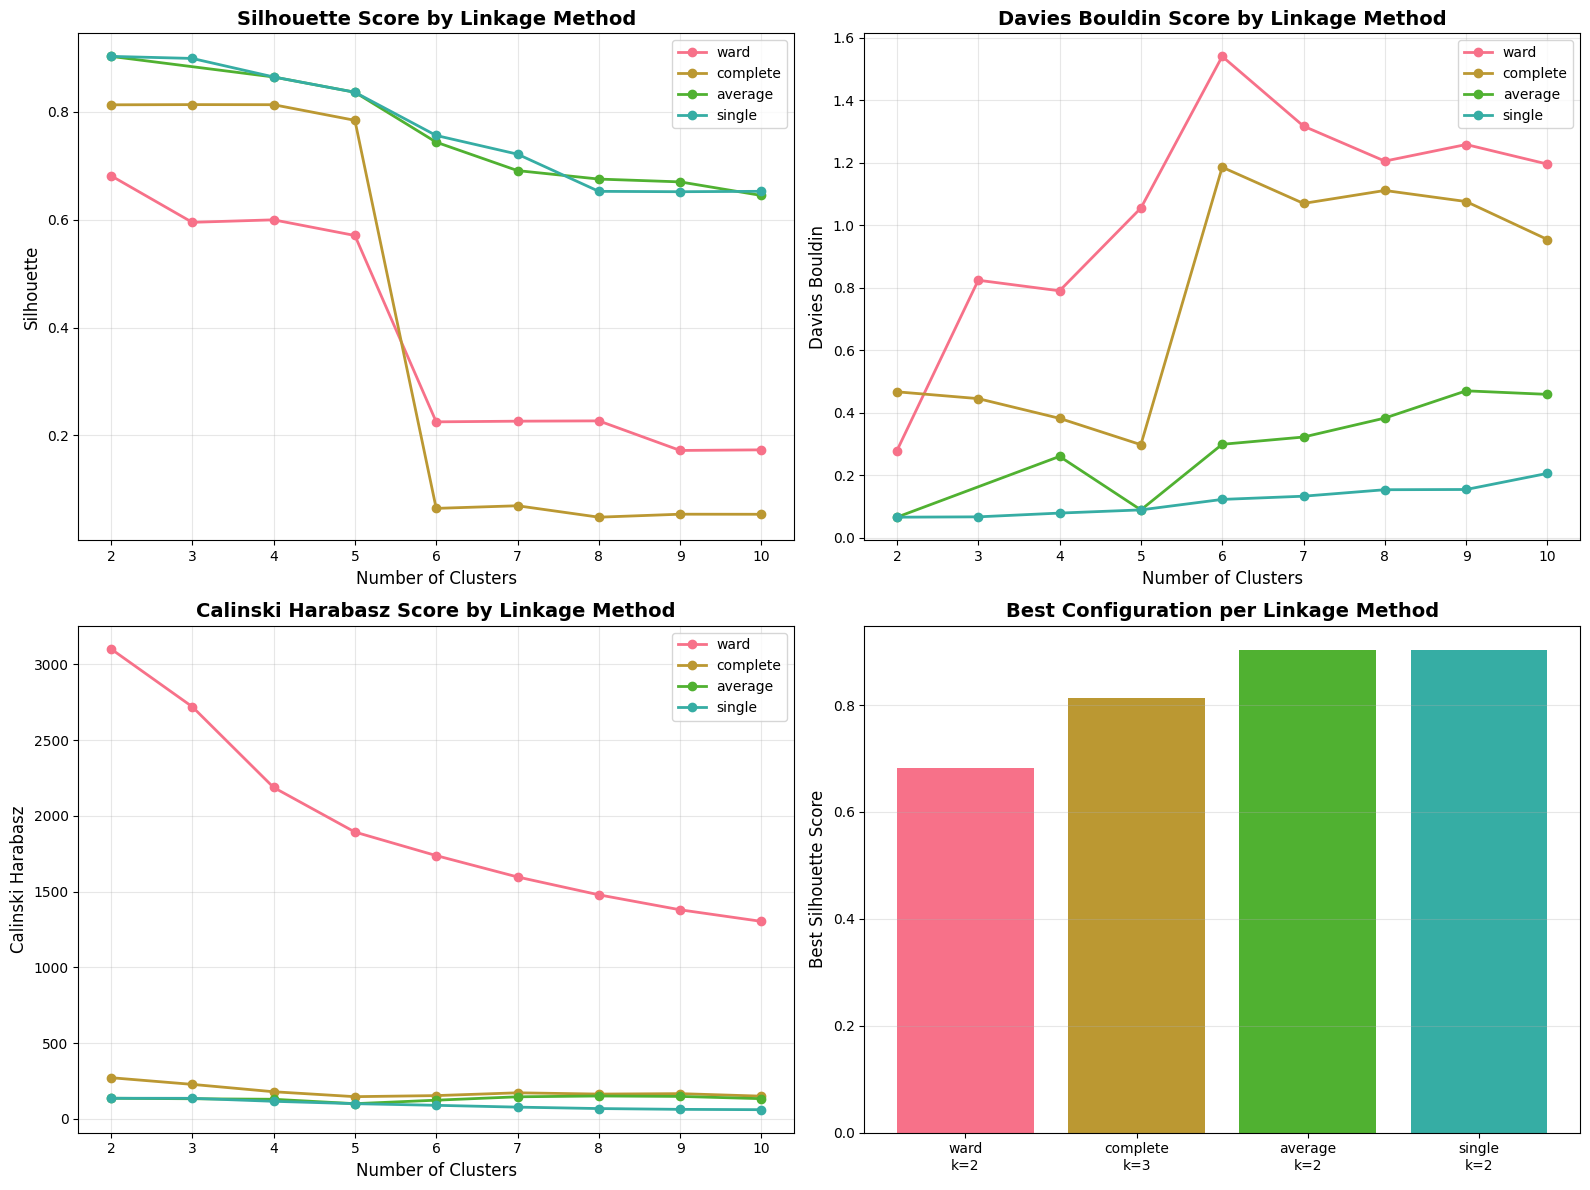


Best configuration for each linkage method:
 linkage  n_clusters  silhouette
    ward           2    0.681824
complete           3    0.813633
 average           2    0.903104
  single           2    0.903104


In [103]:
# Visualize comparison of linkage methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, metric in enumerate(['silhouette', 'davies_bouldin', 'calinski_harabasz']):
    ax = axes[idx // 2, idx % 2]
    
    for linkage_method in linkage_methods:
        method_data = results_df[results_df['linkage'] == linkage_method]
        ax.plot(method_data['n_clusters'], method_data[metric], 
               marker='o', label=linkage_method, linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'{metric.replace("_", " ").title()} Score by Linkage Method', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Find best combination for each metric
ax = axes[1, 1]
best_combinations = []
for linkage_method in linkage_methods:
    method_data = results_df[results_df['linkage'] == linkage_method]
    best_sil = method_data.loc[method_data['silhouette'].idxmax()]
    best_combinations.append({
        'linkage': linkage_method,
        'n_clusters': int(best_sil['n_clusters']),
        'silhouette': best_sil['silhouette']
    })
    ax.bar(f"{linkage_method}\nk={int(best_sil['n_clusters'])}", 
          best_sil['silhouette'], label=linkage_method)

ax.set_ylabel('Best Silhouette Score', fontsize=12)
ax.set_title('Best Configuration per Linkage Method', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.1_linkage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBest configuration for each linkage method:")
best_df = pd.DataFrame(best_combinations)
print(best_df.to_string(index=False))


## 2.3.2 Show and Discuss Different Dendrograms

### Generate Dendrograms for Different Linkage Methods


In [104]:
# For dendrogram visualization, we may need to sample the data if it's too large
# Dendrograms become unreadable with too many points
max_samples_for_dendrogram = 100

if len(X_scaled) > max_samples_for_dendrogram:
    print(f"Sampling {max_samples_for_dendrogram} points for dendrogram visualization...")
    sample_indices = np.random.choice(len(X_scaled), max_samples_for_dendrogram, replace=False)
    X_scaled_dendro = X_scaled[sample_indices]
    print(f"Using {len(X_scaled_dendro)} samples for dendrogram")
else:
    X_scaled_dendro = X_scaled
    sample_indices = np.arange(len(X_scaled))

# Generate linkage matrices for different methods
linkage_matrices = {}
for linkage_method in linkage_methods:
    try:
        if linkage_method == 'ward':
            # Ward requires Euclidean distance
            Z = linkage(X_scaled_dendro, method=linkage_method, metric='euclidean')
        else:
            Z = linkage(X_scaled_dendro, method=linkage_method, metric='euclidean')
        linkage_matrices[linkage_method] = Z
        print(f"Generated linkage matrix for {linkage_method}")
    except Exception as e:
        print(f"Error generating linkage matrix for {linkage_method}: {e}")


Sampling 100 points for dendrogram visualization...
Using 100 samples for dendrogram
Generated linkage matrix for ward
Generated linkage matrix for complete
Generated linkage matrix for average
Generated linkage matrix for single


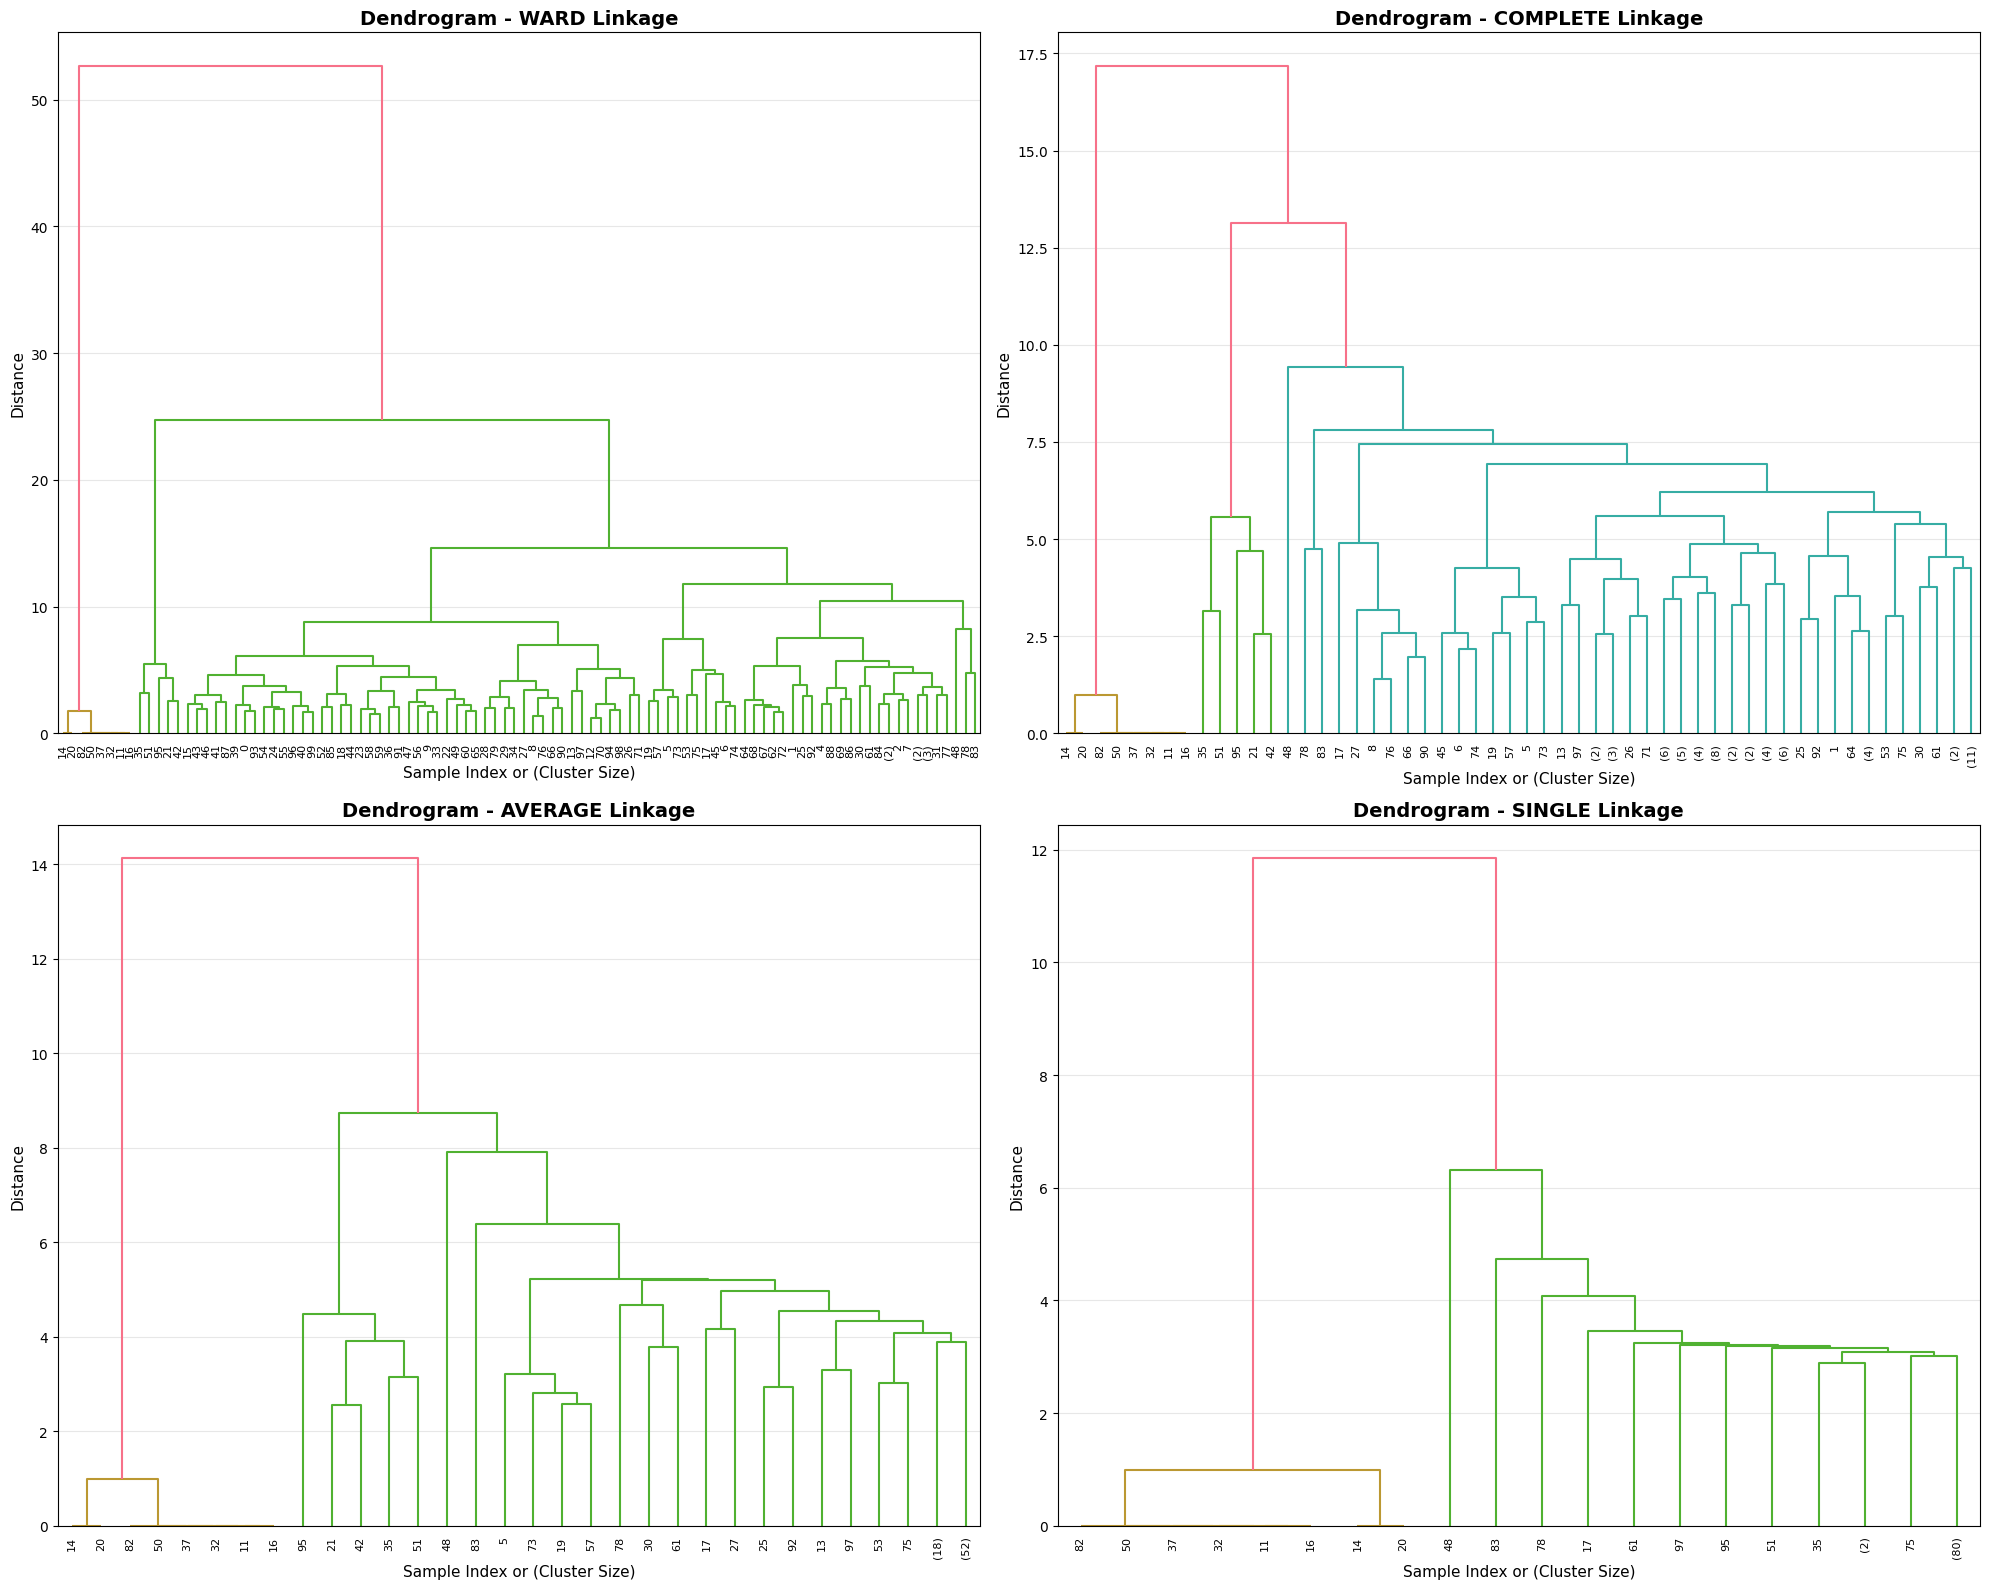

In [105]:
# Plot dendrograms for each linkage method
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, linkage_method in enumerate(linkage_methods):
    if linkage_method in linkage_matrices:
        Z = linkage_matrices[linkage_method]
        
        # Create dendrogram
        dendrogram(
            Z,
            ax=axes[idx],
            leaf_rotation=90,
            leaf_font_size=8,
            truncate_mode='level',
            p=10 if len(X_scaled_dendro) > 50 else None  # Show last 10 merged levels
        )
        
        axes[idx].set_title(f'Dendrogram - {linkage_method.upper()} Linkage', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Sample Index or (Cluster Size)', fontsize=11)
        axes[idx].set_ylabel('Distance', fontsize=11)
        axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_dendrograms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Select Optimal Configuration and Perform Final Clustering


In [114]:
# Select best configuration (highest silhouette score)
best_config = results_df.loc[results_df['silhouette'].idxmax()]
best_config

linkage                 average
n_clusters                    2
silhouette             0.903104
davies_bouldin         0.065833
calinski_harabasz    135.590964
Name: 18, dtype: object

In [118]:
# overwirte manually the best onfig, set params manually:
best_config = results_df.loc[results_df['linkage'] == 'ward'].loc[results_df['n_clusters'] == 4]
# convert df to pandas series
best_config = best_config.iloc[0]
best_config

linkage                     ward
n_clusters                     4
silhouette              0.599947
davies_bouldin          0.790393
calinski_harabasz    2187.779507
Name: 2, dtype: object

In [119]:
optimal_linkage = best_config['linkage']
optimal_n_clusters = int(best_config['n_clusters'])
print(f"\nOptimal Linkage Method: {optimal_linkage}")
print(f"Optimal Number of Clusters: {optimal_n_clusters}")


Optimal Linkage Method: ward
Optimal Number of Clusters: 4


In [120]:
print("="*80)
print("OPTIMAL HIERARCHICAL CLUSTERING CONFIGURATION")
print("="*80)
print(f"Linkage method: {optimal_linkage}")
print(f"Number of clusters: {optimal_n_clusters}")
print(f"Silhouette score: {best_config['silhouette']:.4f}")
print(f"Davies-Bouldin score: {best_config['davies_bouldin']:.4f}")
print(f"Calinski-Harabasz score: {best_config['calinski_harabasz']:.4f}")

# Perform final clustering with optimal parameters
hierarchical_final = AgglomerativeClustering(
    n_clusters=optimal_n_clusters,
    linkage=optimal_linkage
)
cluster_labels = hierarchical_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"\nCluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

# Save clustered data
df_clustered.to_csv(data_path / '2.3_hierarchical_clustered_data.csv', index=False)
print(f"\nClustered data saved to: {data_path / '2.3_hierarchical_clustered_data.csv'}")


OPTIMAL HIERARCHICAL CLUSTERING CONFIGURATION
Linkage method: ward
Number of clusters: 4
Silhouette score: 0.5999
Davies-Bouldin score: 0.7904
Calinski-Harabasz score: 2187.7795

Cluster distribution:
cluster
0     317
1      14
2    4533
3     302
Name: count, dtype: int64

Clustered data saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\Data\2.3_hierarchical_clustered_data.csv


### Cluster Characteristics Analysis


Cluster Characteristics (Mean Values):
   cluster  size  is_dead  abnormal_ratio  qc_fail_ratio  fluid_diversity  \
0        0   317     0.16             0.0           0.02             1.62   
1        1    14     0.00             0.0           0.02             2.21   
2        2  4533     0.08             0.0           0.02             1.54   
3        3   302     0.00             0.0           0.00             0.00   

   max_blood_sodium  num_intermediate  susceptible_ratio  micro_qc_fail  ...  \
0            140.40              0.05               0.05           0.28  ...   
1            140.71              0.07               0.09           0.79  ...   
2            141.06              0.03               0.05           0.15  ...   
3            141.00              0.01               0.24           0.05  ...   

   gender_F  clinical_activity  micro_resistance_score  history_depth  \
0      0.38               2.38                    0.02           7.41   
1      0.29               2.

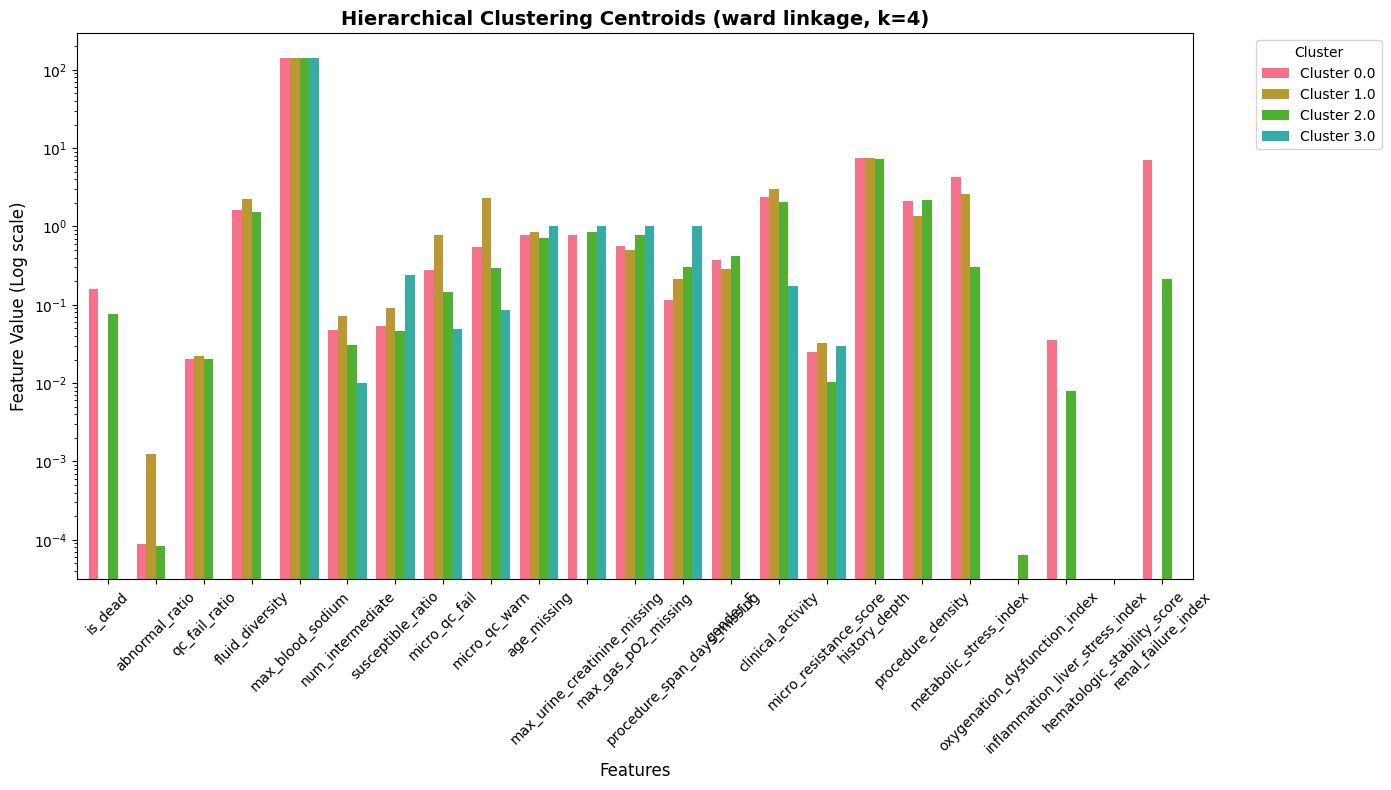

In [93]:
# Analyze cluster characteristics
cluster_stats = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    stats = {'cluster': cluster_id, 'size': len(cluster_data)}
    for feature in numeric_features:
        stats[f'{feature}_mean'] = cluster_data[feature].mean()
        stats[f'{feature}_std'] = cluster_data[feature].std()
    
    cluster_stats.append(stats)

cluster_stats_df = pd.DataFrame(cluster_stats)

# Display mean values for each cluster
print("Cluster Characteristics (Mean Values):")
mean_cols = [col for col in cluster_stats_df.columns if col.endswith('_mean')]
display_df = cluster_stats_df[['cluster', 'size'] + mean_cols].copy()
display_df.columns = ['cluster', 'size'] + [col.replace('_mean', '') for col in mean_cols]
print(display_df.round(2))

# Visualize cluster centroids
centroid_data = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    centroid = cluster_data[numeric_features].mean()
    centroid['cluster'] = cluster_id
    centroid_data.append(centroid)

centroids_df = pd.DataFrame(centroid_data)
centroids_df = centroids_df.set_index('cluster')
centroids_df.index = [f'Cluster {i}' for i in centroids_df.index]

# Plot centroids
fig, ax = plt.subplots(figsize=(14, 8))
centroids_df.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Features', fontsize=12)
ax.set_yscale('log')
ax.set_ylabel('Feature Value (Log scale)', fontsize=12)
ax.set_title(f'Hierarchical Clustering Centroids ({optimal_linkage} linkage, k={optimal_n_clusters})', 
            fontsize=14, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_centroids_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


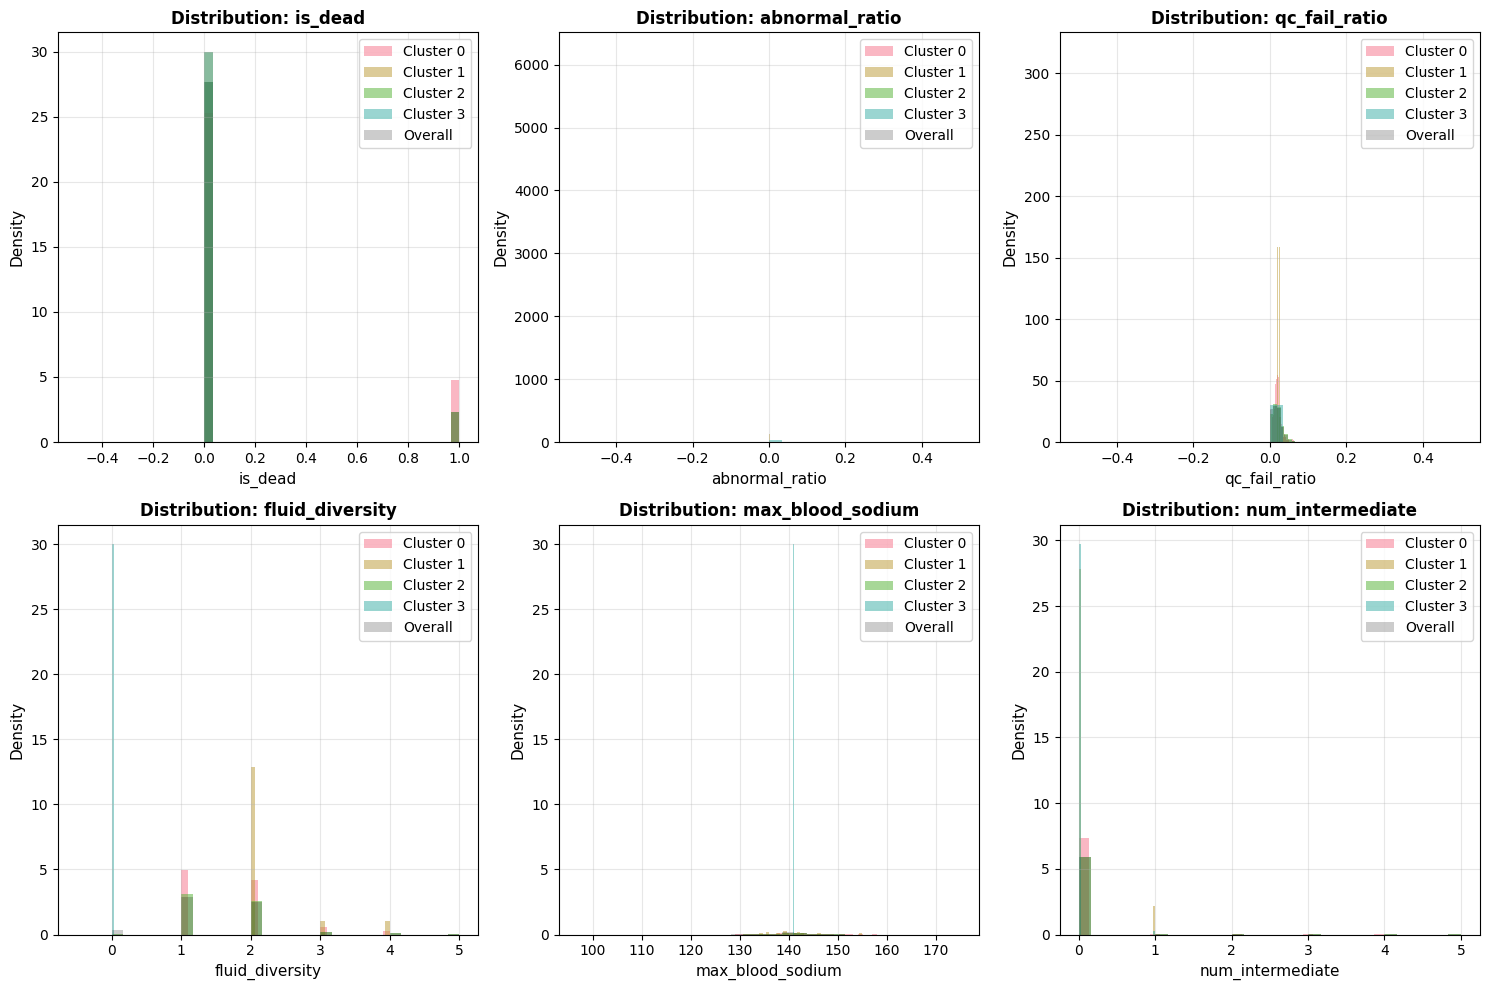

In [94]:
# Compare distributions: clusters vs overall
key_features = numeric_features[:6]  # Select first 6 features

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot distribution for each cluster
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster_id}', bins=30, density=True)
    
    # Plot overall distribution
    ax.hist(df_clustered[feature], alpha=0.2, color='black', 
           label='Overall', bins=30, density=True, linestyle='--', linewidth=2)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


### 2D Visualization using PCA


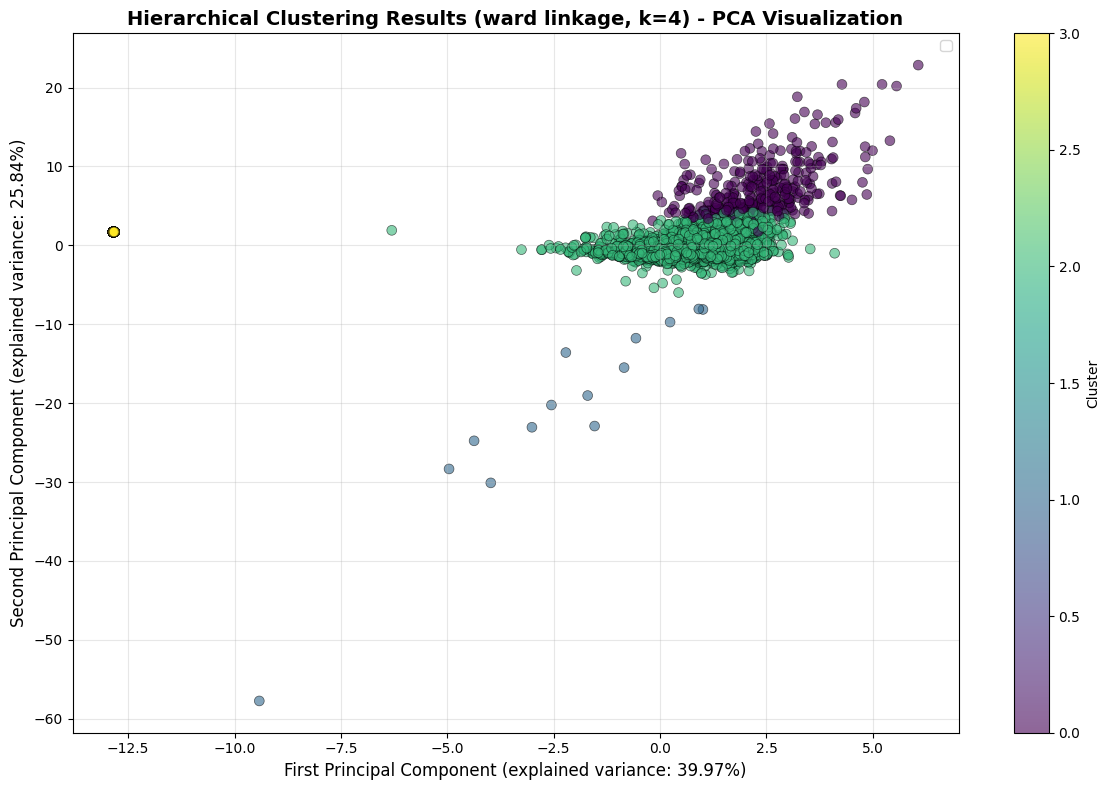

PCA explained variance ratio: [0.39972314 0.2583995 ]
Total explained variance: 65.81%


In [95]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                    cmap='viridis', alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})', 
             fontsize=12)
ax.set_ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})', 
             fontsize=12)
ax.set_title(f'Hierarchical Clustering Results ({optimal_linkage} linkage, k={optimal_n_clusters}) - PCA Visualization', 
            fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.savefig(plots_dir / '2.3.2_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")


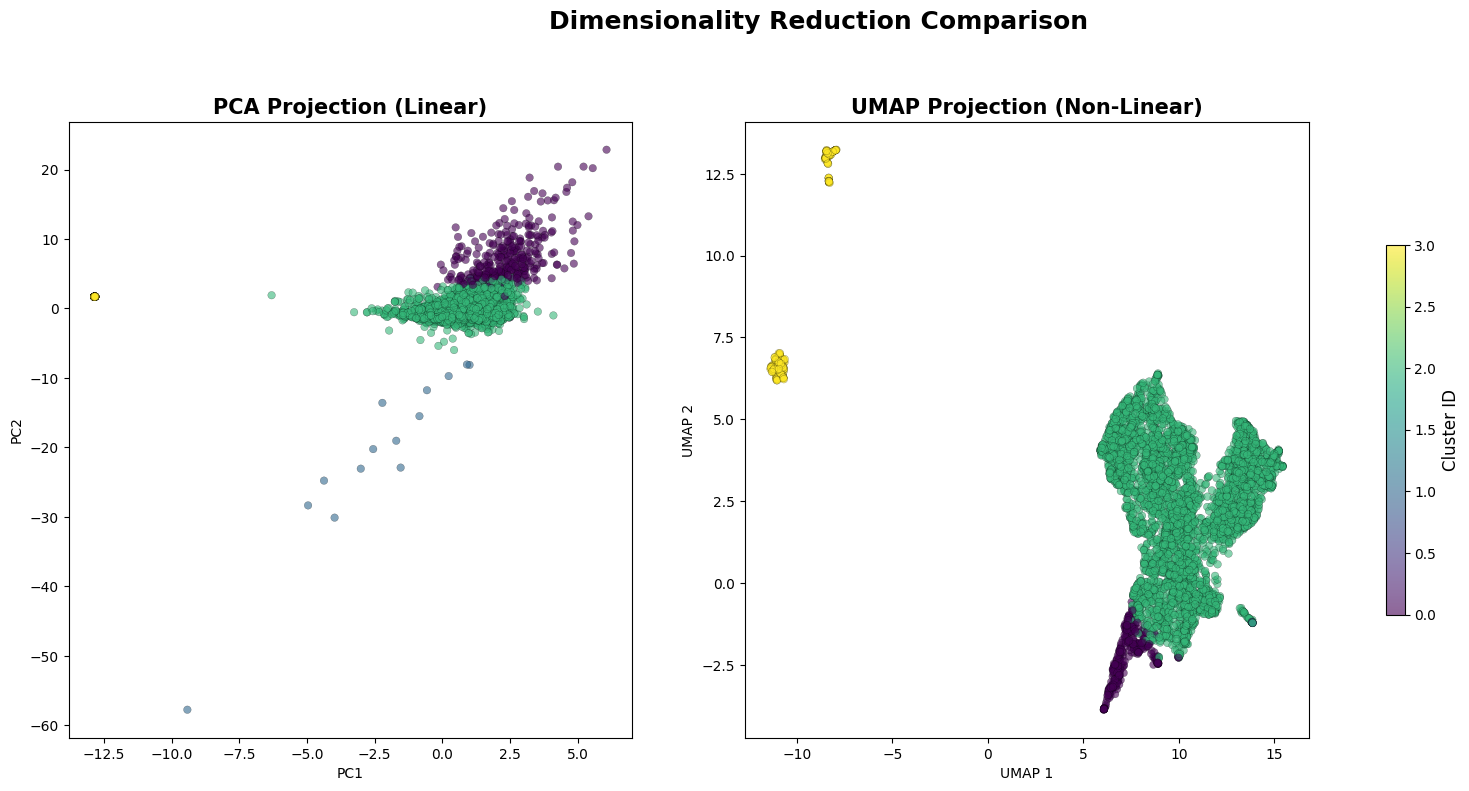

In [96]:
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize UMAP
# n_neighbors: low (5-20) focuses on local detail; high (50+) focuses on global structure
# min_dist: controls how tightly points are packed together
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# 2. Re-run your PCA for the comparison
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Create Side-by-Side Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA
# add centroids of clusters
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax1.set_title('PCA Projection (Linear)', fontsize=15, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Plot UMAP
scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, 
                      cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.2)
ax2.set_title('UMAP Projection (Non-Linear)', fontsize=15, fontweight='bold')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

# Add a shared colorbar
cbar = fig.colorbar(scatter2, ax=[ax1, ax2], location='right', shrink=0.6)
cbar.set_label('Cluster ID', fontsize=12)

plt.suptitle(f'Dimensionality Reduction Comparison', fontsize=18, fontweight='bold', y=1.02)
plt.savefig(plots_dir / '2.3.2_pca_vs_umap_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [98]:
# Create a quick summary table of clinical outcomes
outcome_summary = df_clustered.groupby('cluster').agg({
    'is_dead': 'mean',
    'history_depth': 'mean',
    'metabolic_stress_index': 'mean',
    #'age': 'mean' # only if using the narrow profile
}).round(3)

print("Clinical Outcomes by Cluster:")
print(outcome_summary)

Clinical Outcomes by Cluster:
         is_dead  history_depth  metabolic_stress_index
cluster                                                
0          0.158          7.405                   4.266
1          0.000          7.416                   2.582
2          0.077          7.373                   0.305
3          0.000          0.000                   0.000
